# **Import libraries**

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import keras
from keras import layers
import tensorflow as tf
from keras.utils import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2024-04-15 08:17:51.128226: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 08:17:51.128331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 08:17:51.257122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Use GPU device**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **DNA Sequence Classification**

# Data Preprocessing

In [4]:
#
# Load data from file path
#
def read_data(path):
  f = open(path)
  text = f.read()
  datas = re.split('\n\n',text)
  for i in range(len(datas)):
      x = re.split('\n', datas[i])
      dna_sequence = ''
      for j in range(1, len(x)):
          dna_sequence += x[j]
      datas[i] = dna_sequence
  return datas

In [4]:
#
# Convert data from character to number
#
mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in mapping.keys()):
                check = True
                break
            arr.append(mapping[row[i]])
        if(check == False):
            results.append(arr)
    return results


In [9]:
#
# Reading data
#
mers_data = read_data('/kaggle/input/dna-sequence/MERS.fasta')
sars_data = read_data('/kaggle/input/dna-sequence/SARS.fasta')
covid_data = read_data('/kaggle/input/dna-sequence/COVID-19-2.fasta')
dengue_data = read_data('/kaggle/input/dna-sequence/dengue.fasta')

In [10]:
#
# Encoding data
#
mers_encoding = data_preprocessing(mers_data)
sars_encoding = data_preprocessing(sars_data)
covid_encoding = data_preprocessing(covid_data)
dengue_encoding = data_preprocessing(dengue_data)
# influenza_encoding = data_preprocessing(influenza_data)
# hepatitis_encoding = data_preprocessing(hepatitis_data)

In [12]:
#
# Labeling data
#
mers_label = [0] * len(mers_encoding)
sars_label = [1] * len(sars_encoding)
covid_label = [2] * len(covid_encoding)
# influenza_label = [3] * len(influenza_encoding)
dengue_label = [3] * len(dengue_encoding)
# hepatitis_label = [4] * len(hepatitis_encoding)

In [13]:
#
# Create data with DataFrame format
#
train_data = pd.DataFrame({'dna': mers_encoding + sars_encoding[:3000] + covid_encoding + influenza_encoding[:3000], 'label': mers_label + sars_label[:3000] + covid_label + influenza_label[:3000]})
train_data.head()

,dna,label
0,"[1, 3, 4, 3, 1, 1, 4, 1, 3, 2, 4, 4, 3, 3, 2, ...",0
1,"[1, 2, 4, 1, 4, 1, 3, 2, 4, 3, 1, 4, 2, 2, 4, ...",0
2,"[3, 1, 2, 1, 1, 1, 3, 4, 2, 1, 2, 4, 1, 4, 1, ...",0
3,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0
4,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0


In [14]:
#
# Drop duplicate dna sequence
#
train_data.drop_duplicates(subset=['dna'], inplace=True)
train_data.head()

,dna,label
0,"[1, 3, 4, 3, 1, 1, 4, 1, 3, 2, 4, 4, 3, 3, 2, ...",0
1,"[1, 2, 4, 1, 4, 1, 3, 2, 4, 3, 1, 4, 2, 2, 4, ...",0
2,"[3, 1, 2, 1, 1, 1, 3, 4, 2, 1, 2, 4, 1, 4, 1, ...",0
3,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0
4,"[1, 1, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 1, 3, 2, ...",0


<Axes: xlabel='label', ylabel='count'>

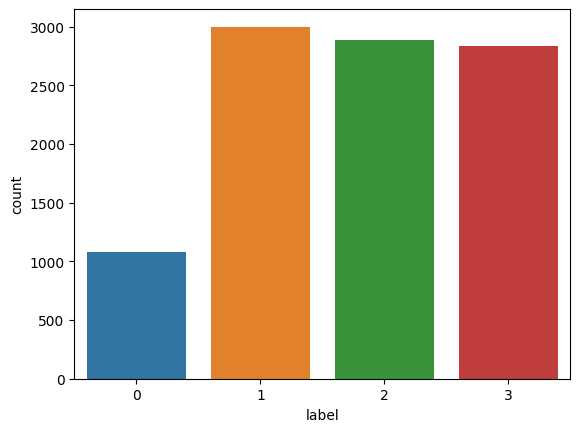

In [15]:
#
# Statistic label for each disease
#
sns.countplot(data=train_data, x = 'label')

In [17]:
#
# get max_length to padding sequence 
# Note that: Devide 2 because devices are not enough :v bruh
#
max_length = int(max([len(x) for x in train_data['dna']]) / 3)
max_length

28308

# Create model

In [18]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=6, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train model

In [19]:
data_padding = pad_sequences(train_data['dna'], maxlen=max_length,value=0,padding='post')

In [20]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(train_data['label'], num_classes = 6)
y_tf = np.array(y_tf, dtype=int)

In [21]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data_padding, y_tf, test_size = 0.2, random_state=42)

In [22]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(dna_train ,label_train, batch_size=32, epochs=5)

Epoch 1/5


I0000 00:00:1713167729.351071      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


246/246 ━━━━━━━━━━━━━━━━━━━━ 69s 186ms/step - accuracy: 0.5935 - loss: 1.2395
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.8265 - loss: 0.5149
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.8698 - loss: 0.3649
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.9074 - loss: 0.2565
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.9303 - loss: 0.1887


# Test model

In [23]:
test_prediction = model.predict(dna_test)
test_prediction[0]

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


array([2.8568463e-04, 3.3917962e-04, 3.2911718e-01, 6.7023754e-01,
       1.7574950e-05, 2.7804290e-06], dtype=float32)

In [25]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [26]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       204
           1       0.98      0.91      0.94       643
           2       0.83      0.83      0.83       585
           3       0.84      0.88      0.86       529

    accuracy                           0.89      1961
   macro avg       0.89      0.90      0.89      1961
weighted avg       0.89      0.89      0.89      1961



In [24]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [25]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5]

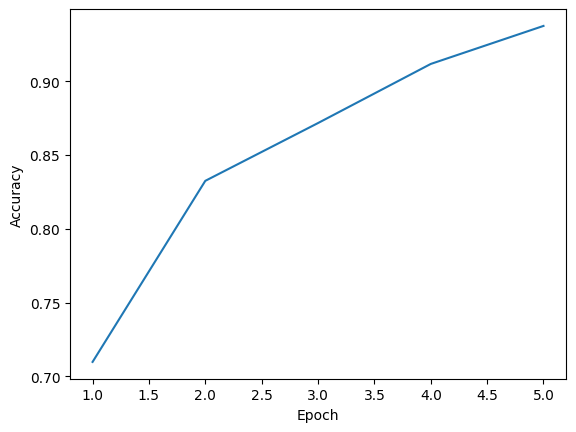

In [41]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(y, accuracy_his)
plt.show()

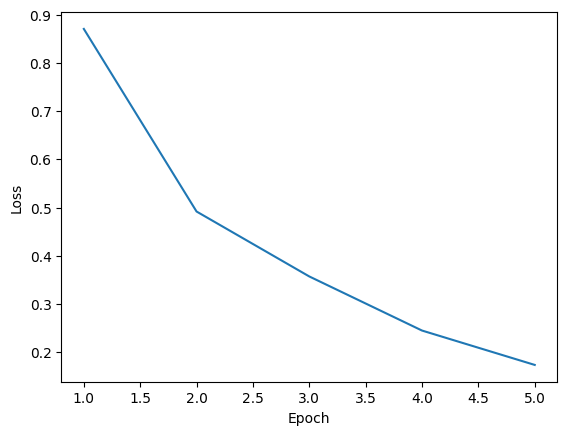

In [42]:
#
# Display loss history
#
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(y, loss_his)
plt.show()

# Protein Sequence Classification

# Data Preprocessing

In [2]:
#
# Change from sequence to int[], using mapping dict
#
amino_acid_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in amino_acid_dict.keys()):
                check = True
                break
            arr.append(amino_acid_dict[row[i]])
        if(check == False):
            results.append(arr)
    return results

In [5]:
#
# Read data
#
protein_mers_data = read_data('/kaggle/input/protein-sequence/MERS2.fasta')
protein_sars_data = read_data('/kaggle/input/protein-sequence/SARS_PROTEIN.fasta')
protein_covid_data = read_data('/kaggle/input/protein-sequence/COVID_PROTEIN.fasta')
protein_dengue_data = read_data('/kaggle/input/protein-sequence/DENGUE_PROTEIN.fasta')

In [6]:
#
# Encode data
#
protein_mers_encoding = data_preprocessing(protein_mers_data)
protein_sars_encoding = data_preprocessing(protein_sars_data)
protein_covid_encoding = data_preprocessing(protein_covid_data)
protein_dengue_encoding = data_preprocessing(protein_dengue_data)
# protein_influenza_encoding = data_preprocessing(protein_influenza_data)
# protein_hepatitis_encoding = data_preprocessing(protein_hepatitis_data)

In [7]:
#
# Create label for each disease
#
protein_mers_label = [0] * len(protein_mers_encoding)
protein_sars_label = [1] * len(protein_sars_encoding)
protein_covid_label = [2] * len(protein_covid_encoding)
# protein_influenza_label = [3] * len(protein_influenza_encoding)
protein_dengue_label = [3] * len(protein_dengue_encoding)
# protein_hepatitis_label = [5] * len(protein_hepatitis_encoding)

In [8]:
#
# Create data in form of 'DataFrame'
#
protein_train_data = pd.DataFrame({'protein': protein_mers_encoding + protein_sars_encoding + protein_covid_encoding + protein_dengue_encoding ,
                           'label': protein_mers_label + protein_sars_label + protein_covid_label + protein_dengue_label})
protein_train_data.head()

,protein,label
0,"[13, 16, 3, 13, 17, 6, 11, 17, 7, 1, 6, 10, 10...",0
1,"[13, 11, 15, 14, 20, 6, 7, 2, 10, 8, 11, 14, 1...",0
2,"[13, 1, 14, 16, 1, 16, 11, 14, 12, 15, 20, 6, ...",0
3,"[13, 7, 7, 16, 11, 17, 4, 20, 15, 16, 17, 16, ...",0
4,"[13, 4, 19, 20, 16, 11, 11, 3, 6, 10, 18, 6, 1...",0


In [9]:
#
# Drop duplicate sequences
#
protein_train_data.drop_duplicates(subset=['protein'], inplace=True)
protein_train_data.head()

,protein,label
0,"[13, 16, 3, 13, 17, 6, 11, 17, 7, 1, 6, 10, 10...",0
1,"[13, 11, 15, 14, 20, 6, 7, 2, 10, 8, 11, 14, 1...",0
2,"[13, 1, 14, 16, 1, 16, 11, 14, 12, 15, 20, 6, ...",0
3,"[13, 7, 7, 16, 11, 17, 4, 20, 15, 16, 17, 16, ...",0
4,"[13, 4, 19, 20, 16, 11, 11, 3, 6, 10, 18, 6, 1...",0


<Axes: xlabel='label', ylabel='count'>

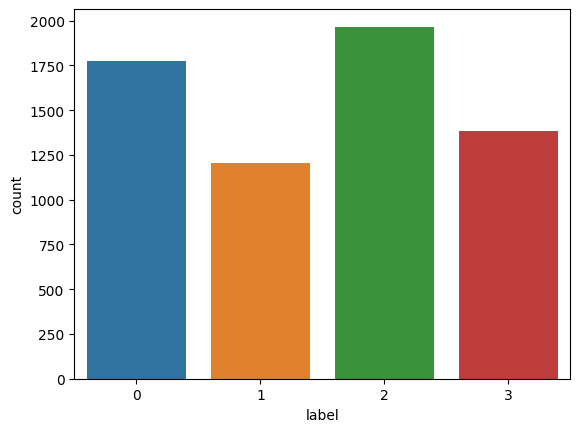

In [10]:
#
# Statistic per label
#
sns.countplot(data=protein_train_data, x = 'label')

In [13]:
#
# Get max_length to pad sequence
#
protein_max_length = int(max([len(x) for x in protein_train_data['protein']]))
protein_max_length

7212

# Create model

In [14]:
import keras
from keras import layers
import tensorflow as tf
# A simpleRNN without any pretrained embeddings and one dense layer
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=protein_max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=6, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train model

In [15]:
#
# Padding sequences
#
protein_data_padding = pad_sequences(protein_train_data['protein'], maxlen=protein_max_length,value=0,padding='post')

In [16]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(protein_train_data['label'], num_classes = 6)
y_tf = np.array(y_tf, dtype=int)

In [17]:
#
# Splitting data
#
protein_train, protein_test, label_train, label_test = train_test_split(protein_data_padding, y_tf, test_size = 0.2, random_state=42)

In [18]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(protein_train ,label_train, batch_size=32, epochs=5)

Epoch 1/5
  2/159 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.1953 - loss: 1.7167 

I0000 00:00:1713169301.300838      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.5630 - loss: 1.0173
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8514 - loss: 0.3662
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8924 - loss: 0.2517
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9350 - loss: 0.1679
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9596 - loss: 0.1073


# Test model

In [20]:
test_prediction = model.predict(protein_test)
test_prediction[0]

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


array([1.0000000e+00, 1.3495629e-17, 9.2226281e-16, 5.2752482e-21,
       1.5494516e-29, 7.1786299e-28], dtype=float32)

In [22]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [23]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       374
           1       0.81      0.73      0.77       246
           2       0.83      0.87      0.85       354
           3       0.99      0.96      0.97       292

    accuracy                           0.90      1266
   macro avg       0.89      0.89      0.89      1266
weighted avg       0.90      0.90      0.90      1266



In [26]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [27]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5]

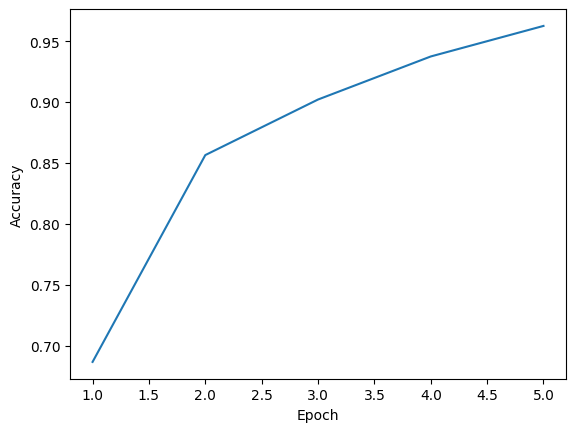

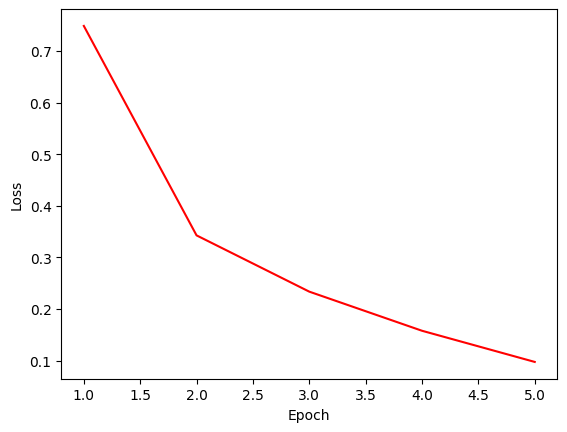

In [33]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.show()

#
# Display loss history
#
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his, color = 'red')
plt.show()

# Rolling

In [ ]:
# import keras
# from keras import layers
# from keras.layers import TimeDistributed
# import tensorflow as tf
# # A simpleRNN without any pretrained embeddings and one dense layer
# optimizers = tf.keras.optimizers.Adam(learning_rate = 0.005, use_ema=True)

# cnn_lstm_model = keras.Sequential()
# cnn_lstm_model.add(layers.Embedding(input_dim=max_length,output_dim=8))
# # cnn_lstm_model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
# # cnn_lstm_model.add(layers.MaxPooling1D(pool_size=2))
# # cnn_lstm_model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# # cnn_lstm_model.add(layers.MaxPooling1D(pool_size=2))

# # cnn_lstm_model.add(layers.LSTM(units=128, activation='tanh', unit_forget_bias=False))

# cnn_lstm_model.add(layers.Flatten())
# cnn_lstm_model.add(layers.Dense(units=256, activation='relu'))
# # cnn_lstm_model.add(layers.Dense(units=128, activation='relu'))
# cnn_lstm_model.add(layers.Dense(units=4, activation='softmax'))

# cnn_lstm_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

# cnn_lstm_model.summary()

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# data_padding, label = ros.fit_resample(data_padding, train_data['label'])

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=300,max_depth=14)
# clf.fit(dna_train, label_train)

In [ ]:
# label_pre = clf.predict(dna_test)
# print(classification_report(label_pre,label_test))
# print(accuracy_score(label_pre,label_test)*100)

In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy_score(test_pre, test_label)

In [ ]:
# mers_data_test = read_data('/kaggle/input/dna-sequence-testing/SARS_TEST.fasta')
# mers_data_encoding = data_preprocessing(mers_data_test)

# influenza_data_test = read_data('/kaggle/input/dna-sequence-testing/INFLUENZA_TEST.fasta')
# influenza_data_encoding = data_preprocessing(influenza_data_test)

In [ ]:
# data_test = mers_data_encoding + influenza_data_encoding[:1000]

In [ ]:
# p = pad_sequences(influenza_data_encoding, maxlen=max_length,value=0,padding='post')

In [ ]:
# data_test_padding = pad_sequences(data_test, maxlen=max_length,value=0,padding='post')

In [ ]:
# import
# loaded_model = keras.saving.load_model("model.keras")

In [ ]:
# results = model.predict(p)
# results[:3]

In [ ]:
# pre = np.argmax(results, axis = 1)
# pre[:3]

In [ ]:
# actual_results = [1] * len(mers_data_encoding) + [3] * 1000

In [ ]:
# unique, counts = np.unique(pre, return_counts=True)
# dict(zip(unique, counts))

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# typeClass = ['CNN','CNN','CNN-LSTM','CNN-LSTM']
# typeEval = ['Label Encoding Training', 'Label Encoding Testing', 'Label Encoding Training', 'Label Encoding Testing']
# accuracy = [0.96, 0.92, 0.95, 0.93]
# accuracy_table = pd.DataFrame({'type': typeClass, 'typeEval': typeEval, 'accuracy': accuracy})

# sns.barplot(data = accuracy_table, x='typeEval', y='accuracy',hue = 'type', saturation=1, palette = "mako")
# plt.xlabel('')
# plt.ylabel('Accuracy (%)')
# plt.show()